#### **Genre Classification**

**PCA**

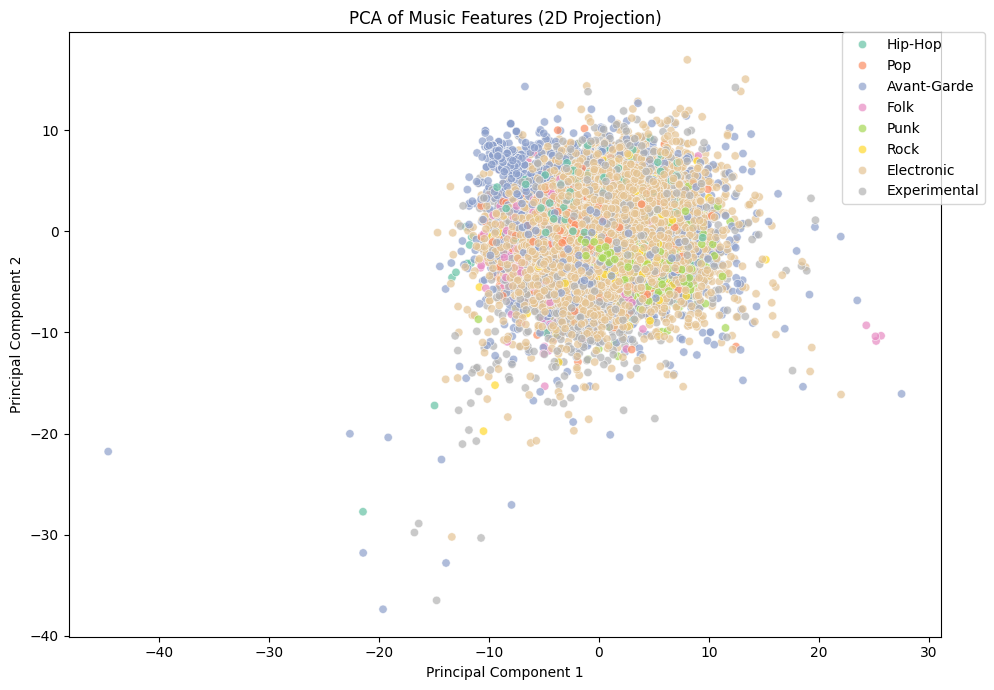

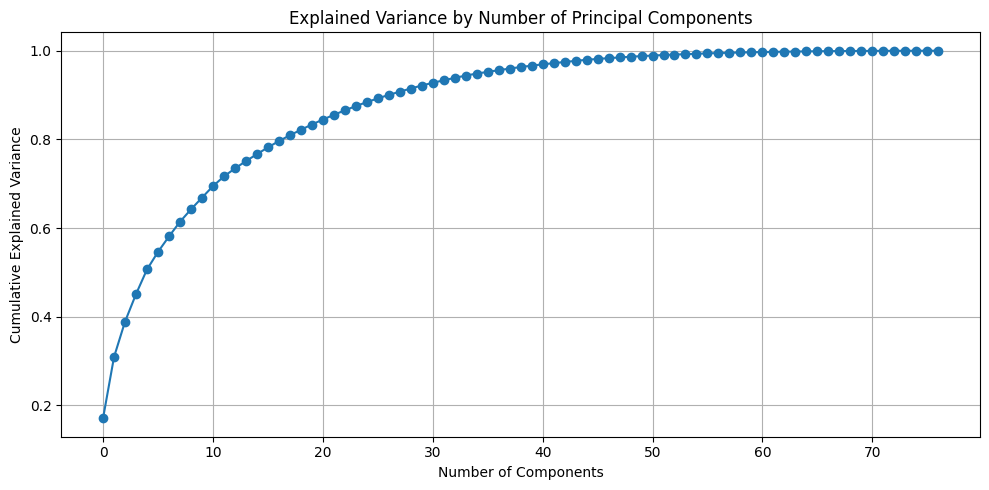

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# === Load Dataset ===
processed_folder = "C:/Users/retae/GitHub/Machine-Learning-Final-Project/data/processed/"
music_df = pd.read_csv(os.path.join(processed_folder, "track_genre_feature.csv"), low_memory=False)

# === Feature Selection ===
feature_cols = [
   'chroma_cens_kurtosis', 'chroma_cens_max', 'chroma_cens_mean', 'chroma_cens_median', 'chroma_cens_min',
   'chroma_cens_skew', 'chroma_cens_std', 'chroma_cqt_kurtosis', 'chroma_cqt_max', 'chroma_cqt_mean',
   'chroma_cqt_median', 'chroma_cqt_min', 'chroma_cqt_skew', 'chroma_cqt_std', 'chroma_stft_kurtosis',
   'chroma_stft_max', 'chroma_stft_mean', 'chroma_stft_median', 'chroma_stft_min', 'chroma_stft_skew',
   'chroma_stft_std', 'mfcc_kurtosis', 'mfcc_max', 'mfcc_mean', 'mfcc_median', 'mfcc_min', 'mfcc_skew',
   'mfcc_std', 'rmse_01_kurtosis', 'rmse_01_max', 'rmse_01_mean', 'rmse_01_median', 'rmse_01_min',
   'rmse_01_skew', 'rmse_01_std', 'spectral_bandwidth_01_kurtosis', 'spectral_bandwidth_01_max',
   'spectral_bandwidth_01_mean', 'spectral_bandwidth_01_median', 'spectral_bandwidth_01_min',
   'spectral_bandwidth_01_skew', 'spectral_bandwidth_01_std', 'spectral_centroid_01_kurtosis',
   'spectral_centroid_01_max', 'spectral_centroid_01_mean', 'spectral_centroid_01_median',
   'spectral_centroid_01_min', 'spectral_centroid_01_skew', 'spectral_centroid_01_std',
   'spectral_contrast_kurtosis', 'spectral_contrast_max', 'spectral_contrast_mean', 'spectral_contrast_median',
   'spectral_contrast_min', 'spectral_contrast_skew', 'spectral_contrast_std', 'spectral_rolloff_01_kurtosis',
   'spectral_rolloff_01_max', 'spectral_rolloff_01_mean', 'spectral_rolloff_01_median',
   'spectral_rolloff_01_min', 'spectral_rolloff_01_skew', 'spectral_rolloff_01_std', 'tonnetz_kurtosis',
   'tonnetz_max', 'tonnetz_mean', 'tonnetz_median', 'tonnetz_min', 'tonnetz_skew', 'tonnetz_std',
   'zcr_01_kurtosis', 'zcr_01_max', 'zcr_01_mean', 'zcr_01_median', 'zcr_01_min', 'zcr_01_skew', 'zcr_01_std'
]

keep_cols = ['track_id', 'primary_genre'] + feature_cols
music_filtered = music_df[keep_cols].dropna()

# === Standardize Features ===
X = music_filtered[feature_cols].values
y = music_filtered['primary_genre'].values
X_scaled = StandardScaler().fit_transform(X)

# === Apply PCA ===
pca = PCA(n_components=8)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

# === Create DataFrame for Plotting ===
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df['Genre'] = y

# === Plot PCA Results ===
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Genre", palette="Set2", alpha=0.7)
plt.title("PCA of Music Features (2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

# === Explained Variance ===
explained_var = PCA().fit(X_scaled).explained_variance_ratio_
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_var), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available! Using GPU: NVIDIA GeForce MX450
Number of CUDA devices: 1
Current CUDA device: 0


**GridSearchCV for Random Forest Classifier Model**

Fitting 5 folds for each of 64 candidates, totalling 320 fits

✅ Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

=== Classification Report ===
              precision    recall  f1-score   support

 Avant-Garde       0.54      0.41      0.46      1880
  Electronic       0.51      0.88      0.65      4346
Experimental       0.55      0.15      0.23      1327
        Folk       0.61      0.41      0.49       797
     Hip-Hop       0.77      0.25      0.38       842
         Pop       0.58      0.18      0.28      1239
        Rock       0.57      0.56      0.57      1416

    accuracy                           0.54     11847
   macro avg       0.59      0.41      0.44     11847
weighted avg       0.56      0.54      0.49     11847



<Figure size 1000x800 with 0 Axes>

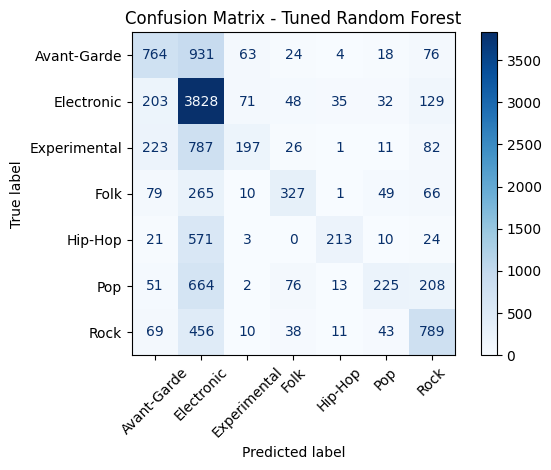

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the preprocessed final dataset
file_path = "C:/Users/retae/GitHub/Machine-Learning-Final-Project/data/processed/final.csv"
df = pd.read_csv(file_path)

# Split into features and labels
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Initialize Random Forest and GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_rf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}")

# Predict and evaluate
y_pred = best_rf.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rf.classes_)

# Plot
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.tight_layout()
plt.show()

**Random Forest Classifier Model**

=== Classification Report ===
              precision    recall  f1-score   support

 Avant-Garde       0.54      0.41      0.46      1880
  Electronic       0.51      0.88      0.65      4346
Experimental       0.55      0.15      0.23      1327
        Folk       0.61      0.41      0.49       797
     Hip-Hop       0.77      0.25      0.38       842
         Pop       0.58      0.18      0.28      1239
        Rock       0.57      0.56      0.57      1416

    accuracy                           0.54     11847
   macro avg       0.59      0.41      0.44     11847
weighted avg       0.56      0.54      0.49     11847



<Figure size 1000x800 with 0 Axes>

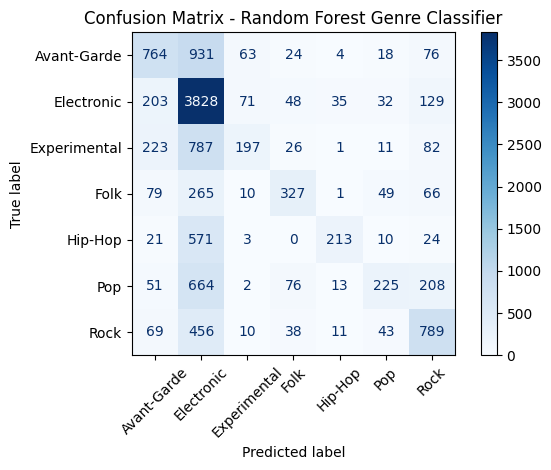

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Load the final preprocessed data
file_path = "C:/Users/retae/GitHub/Machine-Learning-Final-Project/data/processed/final.csv"
df = pd.read_csv(file_path)

# Separate features and labels
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Encode genre labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Initialize and train the Random Forest model
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Decode predictions and true labels back to genre names
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate performance
print("=== Classification Report ===")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Random Forest Genre Classifier")
plt.tight_layout()
plt.show()

# save directory
save_dir = os.path.join("..", "src", "models")
os.makedirs(save_dir, exist_ok=True)

# Save the trained model and labelencoder and genre names and X_test csv
joblib.dump(clf, os.path.join(save_dir, "rf_model.pkl"))
joblib.dump(label_encoder, os.path.join(save_dir, "rf_label_encoder.pkl"))
np.save(os.path.join(save_dir, "rf_genre_classes.npy"), label_encoder.classes_)
X_test.to_csv(os.path.join(save_dir, "rf_X_test.csv"), index=False)

**GridSearch for XGBoost**

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Load data
file_path = "C:/Users/retae/GitHub/Machine-Learning-Final-Project/data/processed/final.csv"
df = pd.read_csv(file_path)

# Separate features and labels
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Now y contains integers

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Best params
print("\n✅ Best Parameters Found:")
print(grid_search.best_params_)
print(f"\n✅ Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Decode predictions back to genre names
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test_labels, y_pred_labels))

Fitting 5 folds for each of 72 candidates, totalling 360 fits

✅ Best Parameters Found:
{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

✅ Best Cross-Validation Accuracy: 0.5510

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

 Avant-Garde       0.53      0.45      0.49      1880
  Electronic       0.56      0.81      0.66      4346
Experimental       0.46      0.21      0.29      1327
        Folk       0.58      0.46      0.51       797
     Hip-Hop       0.62      0.38      0.47       842
         Pop       0.44      0.26      0.32      1239
        Rock       0.57      0.60      0.58      1416

    accuracy                           0.55     11847
   macro avg       0.54      0.45      0.48     11847
weighted avg       0.54      0.55      0.52     11847



**XGBoost Model**

=== Classification Report ===
              precision    recall  f1-score   support

 Avant-Garde       0.53      0.45      0.49      1880
  Electronic       0.56      0.81      0.66      4346
Experimental       0.46      0.21      0.29      1327
        Folk       0.58      0.46      0.51       797
     Hip-Hop       0.62      0.38      0.47       842
         Pop       0.44      0.26      0.32      1239
        Rock       0.57      0.60      0.58      1416

    accuracy                           0.55     11847
   macro avg       0.54      0.45      0.48     11847
weighted avg       0.54      0.55      0.52     11847



<Figure size 1000x800 with 0 Axes>

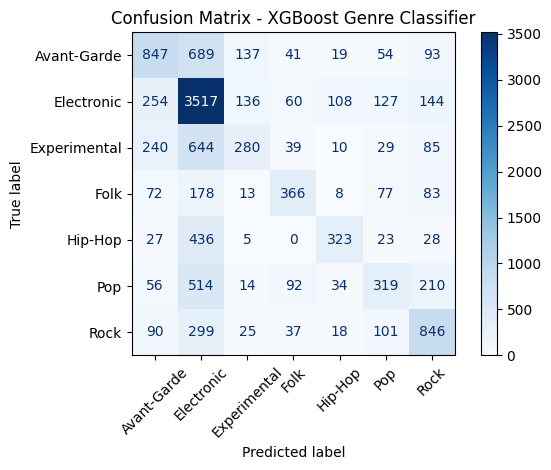

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os

# Suppress warnings from XGBoost
warnings.filterwarnings("ignore")

# Load the final preprocessed data
file_path = "C:/Users/retae/GitHub/Machine-Learning-Final-Project/data/processed/final.csv"
df = pd.read_csv(file_path)

# Separate features and labels
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Encode genre labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    max_depth=10,              
    learning_rate=0.1,              
    n_estimators=200,                
    subsample=0.8,                   
    colsample_bytree=1,              
    eval_metric='mlogloss',
    random_state=42,
    tree_method='hist',
    predictor='gpu_predictor'
)
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test)

# Decode predictions back to genre names for readability
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Print classification report
print("=== Classification Report ===")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - XGBoost Genre Classifier")
plt.tight_layout()
plt.show()

# save directory
save_dir = os.path.join("..", "src", "models")
os.makedirs(save_dir, exist_ok=True)
# Save the trained model and labelencoder
joblib.dump(xgb_clf, os.path.join(save_dir, "xgboost_model.pkl"))
joblib.dump(label_encoder, os.path.join(save_dir, "xgb_label_encoder.pkl"))
np.save(os.path.join(save_dir, "xgb_genre_classes.npy"), label_encoder.classes_)
X_test.to_csv(os.path.join(save_dir, "xgb_X_test.csv"), index=False)

**MLP**

Using device: cuda
Epoch [1/250] Loss: 1.2227 | Val Acc: 0.5033
Epoch [2/250] Loss: 1.1899 | Val Acc: 0.5165
Epoch [3/250] Loss: 1.4895 | Val Acc: 0.5257
Epoch [4/250] Loss: 1.3219 | Val Acc: 0.5321
Epoch [5/250] Loss: 1.2035 | Val Acc: 0.5321
Epoch [6/250] Loss: 0.9838 | Val Acc: 0.5408
Epoch [7/250] Loss: 1.5717 | Val Acc: 0.5381
Epoch [8/250] Loss: 1.0473 | Val Acc: 0.5450
Epoch [9/250] Loss: 1.0547 | Val Acc: 0.5357
Epoch [10/250] Loss: 1.7249 | Val Acc: 0.5478
Epoch [11/250] Loss: 0.9907 | Val Acc: 0.5493
Epoch [12/250] Loss: 1.3293 | Val Acc: 0.5513
Epoch [13/250] Loss: 1.1863 | Val Acc: 0.5552
Epoch [14/250] Loss: 0.9121 | Val Acc: 0.5524
Epoch [15/250] Loss: 1.1629 | Val Acc: 0.5537
Epoch [16/250] Loss: 1.7101 | Val Acc: 0.5522
Epoch [17/250] Loss: 1.2199 | Val Acc: 0.5586
Epoch [18/250] Loss: 1.2498 | Val Acc: 0.5608
Epoch [19/250] Loss: 1.0050 | Val Acc: 0.5585
Epoch [20/250] Loss: 1.3786 | Val Acc: 0.5572
Epoch [21/250] Loss: 1.1887 | Val Acc: 0.5640
Epoch [22/250] Loss: 1.1

<Figure size 1200x800 with 0 Axes>

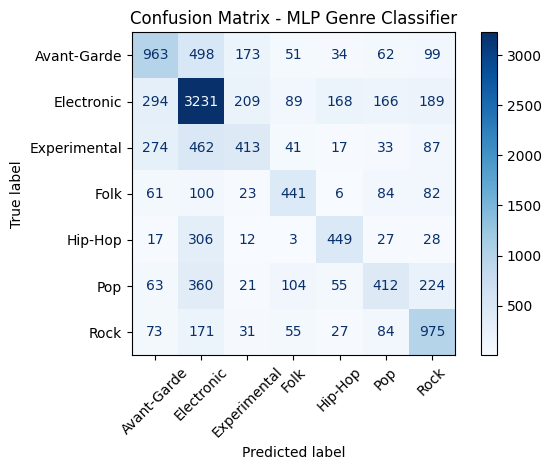

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import warnings
import joblib
import os

# Load data
warnings.filterwarnings("ignore", category=UserWarning)
file_path = "C:/Users/retae/GitHub/Machine-Learning-Final-Project/data/processed/final.csv"
df = pd.read_csv(file_path)

# feature selection 
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create dataset and dataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Detect GPU Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define MLP
class DetailedMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(DetailedMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
input_size = X_train.shape[1]
output_size = len(label_encoder.classes_)
model = DetailedMLP(input_size, output_size).to(device)

# Move test tensors to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Set up training tools
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

# train model
best_acc = 0
epochs_without_improve = 0
patience = 20
num_epochs = 250

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, preds = torch.max(outputs, 1)
        val_acc = accuracy_score(y_test_tensor.cpu().numpy(), preds.cpu().numpy())
        scheduler.step(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improve = 0
    else:
        epochs_without_improve += 1
        if epochs_without_improve >= patience:
            print("Early stopping.")
            break

# === Final Evaluation ===
model.load_state_dict(best_model_state)

save_dir = os.path.join("..", "src", "models")
os.makedirs(save_dir, exist_ok=True)
# Save model state dict, labelencoder, and standard scaler
torch.save(model.state_dict(), os.path.join(save_dir, "mlp_model.pth"))
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))
np.save(os.path.join(save_dir, "genre_classes.npy"), label_encoder.classes_)
torch.save(X_test_tensor, os.path.join(save_dir, "X_test_tensor.pt"))

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, final_preds = torch.max(outputs, 1)

y_pred = final_preds.cpu().numpy()
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(12, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - MLP Genre Classifier")
plt.tight_layout()
plt.show()

**Ensemble**


=== Classification Report: Ensemble ===
              precision    recall  f1-score   support

 Avant-Garde       0.57      0.49      0.53      1880
  Electronic       0.58      0.82      0.68      4346
Experimental       0.53      0.25      0.34      1327
        Folk       0.59      0.53      0.56       797
     Hip-Hop       0.66      0.44      0.53       842
         Pop       0.52      0.28      0.37      1239
        Rock       0.59      0.66      0.62      1416

    accuracy                           0.58     11847
   macro avg       0.58      0.49      0.52     11847
weighted avg       0.58      0.58      0.56     11847



<Figure size 1200x800 with 0 Axes>

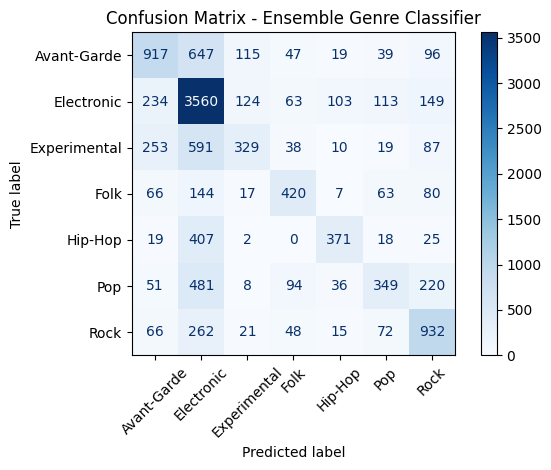

In [10]:
import numpy as np

# === 1. Get Probabilities ===
rf_probs = clf.predict_proba(X_test)            # Random Forest
xgb_probs = xgb_clf.predict_proba(X_test)           # XGBoost
mlp_probs = torch.softmax(model(X_test_tensor), dim=1).detach().cpu().numpy() # MLP (PyTorch)

# === 2. Apply Weights ===
rf_weight = 0.30
xgb_weight = 0.30
mlp_weight = 0.40

# === 3. Weighted Average of Probabilities ===
ensemble_probs = (
    rf_weight * rf_probs +
    xgb_weight * xgb_probs +
    mlp_weight * mlp_probs
)

# === 4. Predict Final Classes ===
ensemble_preds = np.argmax(ensemble_probs, axis=1)
ensemble_pred_labels = label_encoder.inverse_transform(ensemble_preds)

# === 5. Evaluate Ensemble ===
print("\n=== Classification Report: Ensemble ===")
print(classification_report(y_test_labels, ensemble_pred_labels))

# === 6. Confusion Matrix ===
ensemble_cm = confusion_matrix(y_test_labels, ensemble_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(12, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Ensemble Genre Classifier")
plt.tight_layout()
plt.show()